# Imports

In [2]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import GridSearchCV

## some data constants

In [3]:
subjects = 40
photos = 10
samples = subjects * photos
width = 92
length = 112
pixels = 10304

# Load Data

In [4]:
# inisialize a zeros vector to stack features on and an empty labels vector
features = np.zeros((1, pixels))
labels = []

for i in range(1, subjects+1):
    for j in range(1, photos+1):
        img = Image.open(f"data/s{i}/{j}.pgm")
        img = np.asarray(img)
        img = img.reshape(1,-1)
        
        features = np.vstack((features, img))
        labels.append(i)

# drop the initial zeros row
features = features[1:]
labels = np.array(labels)


In [5]:
features.shape

(400, 10304)

In [6]:
labels.shape

(400,)

# View A Few Samples

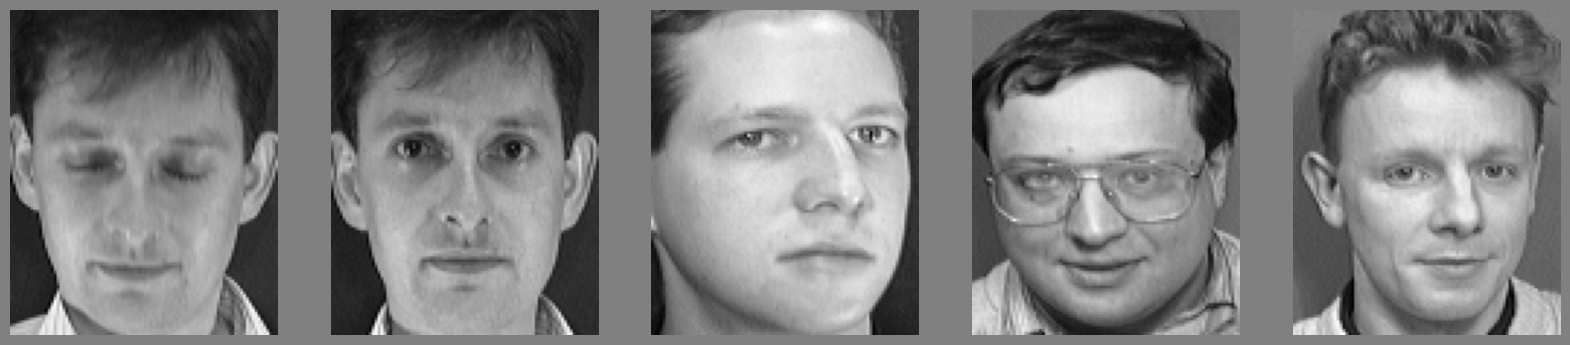

In [7]:
fig, ax = plt.subplots(1, 5, figsize = (20,30))
fig.patch.set_facecolor('grey')

for i in range(5):
    ax[i].imshow(features[np.random.randint(0, 400),:].reshape(length, width), cmap="gray")
    ax[i].axis("off")

# Split The Data

In [8]:
x_train, x_eval, y_train, y_eval = train_test_split(features, labels, test_size=0.5,
                                                     random_state=0, stratify=labels,)

In [9]:
pd.value_counts(y_train)

13    5
34    5
1     5
20    5
32    5
8     5
19    5
28    5
31    5
5     5
38    5
23    5
24    5
37    5
35    5
33    5
7     5
2     5
6     5
26    5
10    5
39    5
30    5
36    5
40    5
29    5
18    5
27    5
4     5
16    5
21    5
25    5
11    5
3     5
17    5
9     5
22    5
15    5
14    5
12    5
Name: count, dtype: int64

# PCA 

In [10]:
# calculate the mean
mean = np.mean(features, axis=0)
mean.shape

(10304,)

In [11]:
# center the data
x_meaned = features - mean
x_meaned.shape

(400, 10304)

In [12]:
# calculate covariance matrix
covariance = np.cov(x_meaned, rowvar=False)
covariance.shape

(10304, 10304)

In [13]:
eig_values, eig_vectors = np.linalg.eigh(covariance)    # calculate eigen values and vectors
eig_values = np.flip(eig_values)                        # flip values to get the descending order
eig_vectors = np.flip(eig_vectors, axis=1)              # flip vectors to get the descending order

In [36]:
# define the alphas we will test
alphas = [i/100 for i in range(70, 95, 1)]

# calculate sum of eigen values for later calculations
eigen_sum = eig_values.sum()

In [37]:
# calculate the least dimensions that satisfy every alpha
dimensions = []
for alpha in alphas:
    acc = eig_values[0]
    i = 1

    while acc / eigen_sum < alpha:
        acc += eig_values[i]
        i += 1
        
    dimensions.append(i) 


In [38]:
dimensions

[20,
 22,
 24,
 26,
 28,
 30,
 32,
 35,
 38,
 41,
 44,
 48,
 52,
 57,
 62,
 68,
 75,
 82,
 91,
 100,
 111,
 123,
 136,
 152,
 169]

In [39]:
# get the basis for every alpha
basis = [np.array(eig_vectors[:,0:dimension]) for dimension in dimensions]
[base.shape for base in basis]

[(10304, 20),
 (10304, 22),
 (10304, 24),
 (10304, 26),
 (10304, 28),
 (10304, 30),
 (10304, 32),
 (10304, 35),
 (10304, 38),
 (10304, 41),
 (10304, 44),
 (10304, 48),
 (10304, 52),
 (10304, 57),
 (10304, 62),
 (10304, 68),
 (10304, 75),
 (10304, 82),
 (10304, 91),
 (10304, 100),
 (10304, 111),
 (10304, 123),
 (10304, 136),
 (10304, 152),
 (10304, 169)]

In [40]:
# get the projections on every basis
train_meaned = x_train - mean
test_meaned = x_eval - mean
train_projections = [train_meaned @ base for base in basis]
test_projections = [test_meaned @ base for base in basis]

In [41]:
[projection.shape for projection in train_projections]

[(200, 20),
 (200, 22),
 (200, 24),
 (200, 26),
 (200, 28),
 (200, 30),
 (200, 32),
 (200, 35),
 (200, 38),
 (200, 41),
 (200, 44),
 (200, 48),
 (200, 52),
 (200, 57),
 (200, 62),
 (200, 68),
 (200, 75),
 (200, 82),
 (200, 91),
 (200, 100),
 (200, 111),
 (200, 123),
 (200, 136),
 (200, 152),
 (200, 169)]

In [42]:
train_reconstructions = np.array([proj @ base.T + mean for proj,base in zip(train_projections, basis)])

In [43]:
train_reconstructions.shape

(25, 200, 10304)

# Visialize The Eigen Faces 

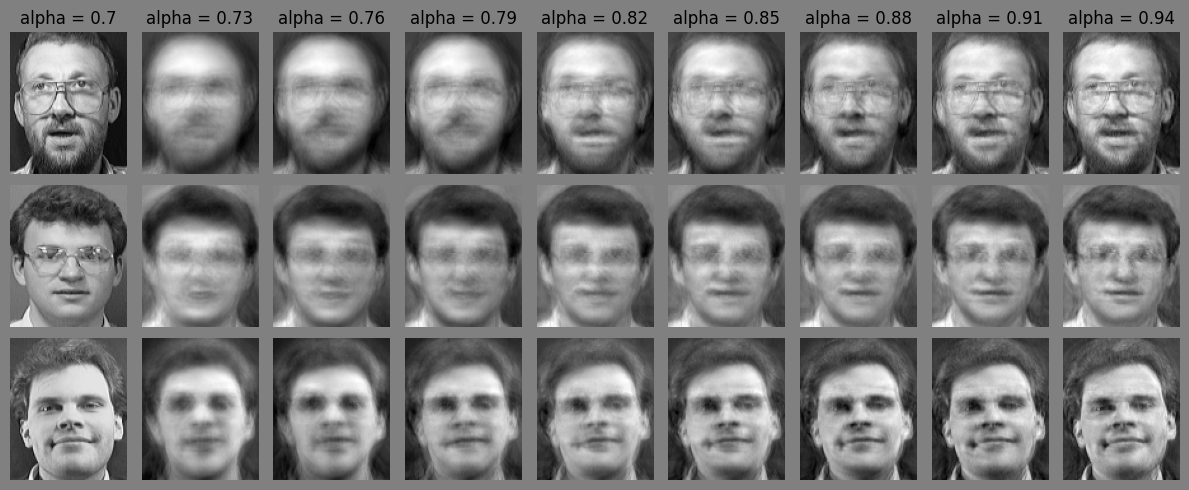

In [75]:
rows = (len(alphas))
cols = 3

rng = range(0, rows, (rows//8))
rows = len(list(rng))

fig, ax = plt.subplots(cols, rows, figsize = (12,5))
fig.patch.set_color("grey")
ax[0][0].set_title("original")

for i, a in enumerate(rng):
    ax[0][i].set_title(f"alpha = {alphas[a]}")

for i in range(cols):
    ind = np.random.randint(0, len(x_train))
    ax[i][0].imshow(x_train[ind,:].reshape(length, width), cmap="gray")
    ax[i][0].axis("off")

    for j, a in zip(range(1, rows), rng):
        img = train_reconstructions[a][ind]

        ax[i][j].imshow(img.reshape(length, width), cmap="gray")
        ax[i][j].axis("off")
fig.tight_layout()

# Train the model

In [45]:
models = [KNN() for _ in range(len(alphas))]

params = {
    "n_neighbors": list(range(1,10,2))
}

models_cv = [GridSearchCV(model, param_grid=params, cv=5,
                       return_train_score=True, scoring="accuracy")
                       for model in models]

In [46]:
test_accuracies = []
for i, proj in enumerate(train_projections):
    models_cv[i].fit(proj, y_train)
    results = pd.DataFrame(models_cv[i].cv_results_)
    knn_selected_results = results[["param_n_neighbors", "mean_test_score", "mean_train_score"]]

    pred = models_cv[i].best_estimator_.predict(test_projections[i])
    acc = np.mean(pred == y_eval)
    test_accuracies.append(acc)

    print(f"alpha: {alphas[i]}\n", f"best fit test accuracy = {acc}\n", knn_selected_results, "\n\n", sep="")


alpha: 0.7
best fit test accuracy = 0.91
  param_n_neighbors  mean_test_score  mean_train_score
0                 1             0.92           1.00000
1                 3             0.82           0.91375
2                 5             0.74           0.84750
3                 7             0.68           0.76875
4                 9             0.64           0.71250


alpha: 0.71
best fit test accuracy = 0.92
  param_n_neighbors  mean_test_score  mean_train_score
0                 1            0.920           1.00000
1                 3            0.815           0.91875
2                 5            0.760           0.84625
3                 7            0.685           0.78500
4                 9            0.660           0.72750


alpha: 0.72
best fit test accuracy = 0.92
  param_n_neighbors  mean_test_score  mean_train_score
0                 1            0.925            1.0000
1                 3            0.825            0.9225
2                 5            0.770          

Text(0, 0.5, 'test accuracy')

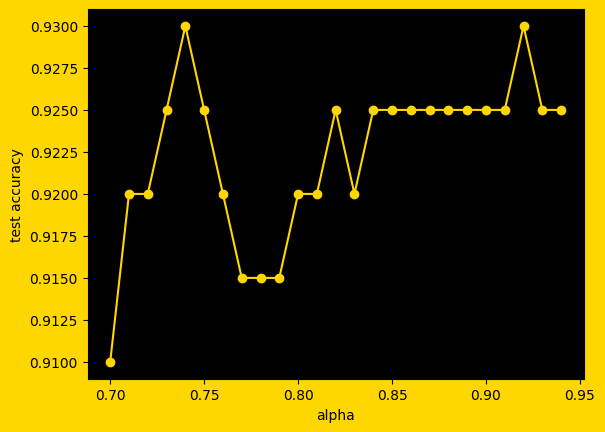

In [47]:
fig = plt.figure()
fig.patch.set_facecolor('gold')

ax = plt.axes()
ax.set_facecolor("black")


plt.plot(alphas, test_accuracies, linestyle='-', marker='o', color='gold')
plt.xlabel("alpha")
plt.ylabel("test accuracy")

In [48]:
def test(model, x, images, y, tests = 3):
    
    fig, axes = plt.subplots(1, tests, figsize=(8,8))
    fig.patch.set_color("grey")

    for ax in axes:
        ind = np.random.randint(0, len(x))
        features = x[ind].reshape(1,-1)
        label = y[ind]
        img = images[ind]
        pred = model.predict(features)
    
        ax.set_title(f"label = {label} \nprediction = {pred.item()}")
        ax.imshow(img.reshape(length, width), cmap="gray")
        ax.axis("off")

    fig.tight_layout()


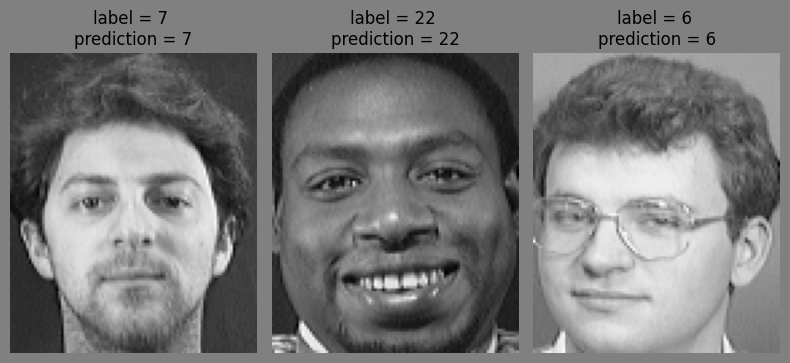

In [49]:
test(models_cv[2].best_estimator_, train_projections[2], x_train, y_train)

# Try 70-30 train-test split

In [50]:
x2_train, x2_eval, y2_train, y2_eval = train_test_split(features, labels, train_size=0.7,
                                                        random_state=0, stratify=labels,)

In [51]:
pd.value_counts(y2_train)

32    7
27    7
35    7
39    7
36    7
11    7
34    7
40    7
17    7
12    7
29    7
1     7
22    7
24    7
15    7
18    7
19    7
9     7
16    7
31    7
30    7
21    7
8     7
10    7
6     7
38    7
26    7
14    7
13    7
33    7
23    7
2     7
25    7
37    7
7     7
4     7
28    7
5     7
3     7
20    7
Name: count, dtype: int64

In [52]:
# get the projections on every basis
train2_meaned = x2_train - mean
test2_meaned = x2_eval - mean
train2_projections = [train2_meaned @ base for base in basis]
test2_projections = [test2_meaned @ base for base in basis]

In [53]:
models2 = [KNN() for _ in range(len(alphas))]

params = {
    "n_neighbors": list(range(1,10,2))
}

models2_cv = [GridSearchCV(model, param_grid=params, cv=5,
                       return_train_score=True, scoring="accuracy")
                       for model in models2]

In [54]:
test_accuracies = []
for i, proj in enumerate(train2_projections):
    models2_cv[i].fit(proj, y2_train)
    results = pd.DataFrame(models2_cv[i].cv_results_)
    knn_selected_results = results[["param_n_neighbors", "mean_test_score", "mean_train_score"]]

    pred = models2_cv[i].best_estimator_.predict(test2_projections[i])
    acc = np.mean(pred == y2_eval)
    test_accuracies.append(acc)

    print(f"alpha: {alphas[i]}\n", f"best fit test accuracy = {acc}\n", knn_selected_results, "\n\n", sep="")

alpha: 0.7
best fit test accuracy = 0.9583333333333334
  param_n_neighbors  mean_test_score  mean_train_score
0                 1         0.946429          1.000000
1                 3         0.864286          0.952679
2                 5         0.817857          0.905357
3                 7         0.757143          0.853571
4                 9         0.721429          0.812500


alpha: 0.71
best fit test accuracy = 0.9583333333333334
  param_n_neighbors  mean_test_score  mean_train_score
0                 1         0.950000          1.000000
1                 3         0.867857          0.958036
2                 5         0.828571          0.910714
3                 7         0.767857          0.860714
4                 9         0.735714          0.812500


alpha: 0.72
best fit test accuracy = 0.9666666666666667
  param_n_neighbors  mean_test_score  mean_train_score
0                 1         0.953571          1.000000
1                 3         0.889286          0.958929
2   

Text(0, 0.5, 'test accuracy')

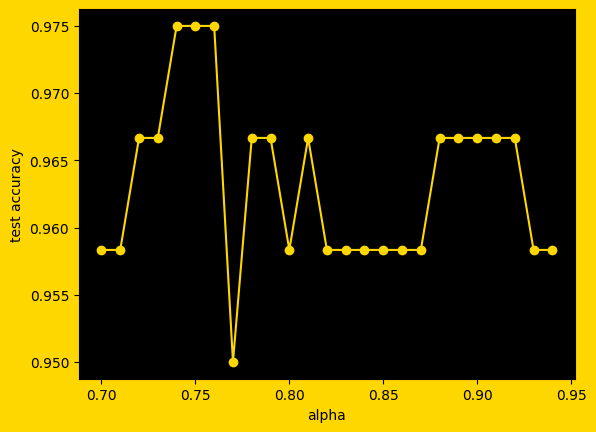

In [55]:
fig = plt.figure()
fig.patch.set_facecolor('gold')

ax = plt.axes()
ax.set_facecolor("black")


plt.plot(alphas, test_accuracies, linestyle='-', marker='o', color='gold')
plt.xlabel("alpha")
plt.ylabel("test accuracy")

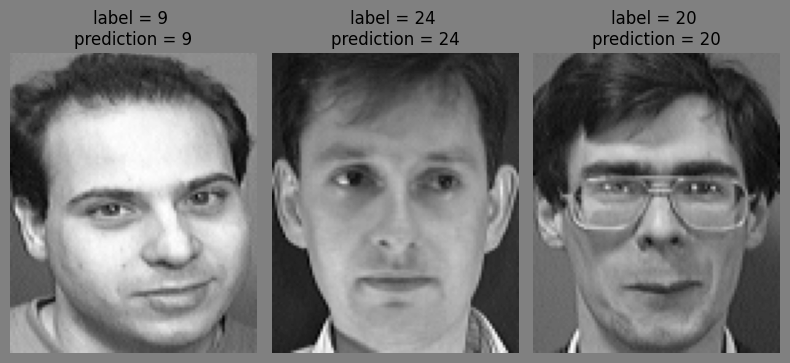

In [56]:
test(models2_cv[2].best_estimator_, train2_projections[2], x2_train, y2_train)